In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

# Escolhendo a paleta da visao 
import mplcyberpunk
plt.style.use("cyberpunk")

# Ajuste para ver todas as colunas da base
pd.options.display.max_columns = 10000

In [260]:
# Analisando tabela de Alunos
tbAluno = pd.read_csv('database/tbAluno.csv')
tbAluno.shape

(2238, 56)

In [261]:
# Printando todas as colunas para que possamos analisar
for c in tbAluno.columns:
    print(c)

IdAluno
NomeAluno
NomeAbreviado
IdUnidade
Sexo
EstadoCivil
DataNascimento
IdPai
IdMae
IdResponsavel
IdTipoResponsavel
Naturalidade
Nacionalidade
TipoSangue
PlanoSaude
Alergia
Medicamento
IdEstabelecimentoEnsinoAnterior
IdReligiao
AnoConclusao
CorRaca
StDeficienciaCegueira
StDeficienciaBaixaVisao
StDeficienciaSurdez
StDeficienciaAuditiva
StDeficienciaFisica
StDeficienciaSurdoCegueira
StDeficienciaMultipla
StDeficienciaMental
_IdResponsavel_CadastroVinculado
StFalecido
EnsinoMedio_IdEstabelecimentoEnsino
EnsinoMedio_AnoConclusao
StDeficienciaAutismoInfantil
StDeficienciaSindromeAsperger
StDeficienciaSindromeRett
StDeficienciaTrastornoDesintegrativo
StDeficienciaAltasHabilidades
NomeCivil
StAppComunicacao_Sincronizado
IdTipoResponsavelPai
IdTipoResponsavelMae
StRecursoAuxilioLedor
StRecursoAuxilioTranscricao
StRecursoGuiaInterprete
StRecursoTradutorInterpreteDeLibras
StRecursoLeituraLabial
StRecursoMaterialDidaticoProvaBraille
StRecursoProvaAmpliada
StRecursoProvaSuperampliada
StRecursoCd

In [262]:
# Contar o número de alunos únicos na base de dados
print(f'[tbAluno] - Há {tbAluno.IdAluno.nunique()} e alunos distintos na base!!')
# print(f'[tbAluno] - Há {tbAluno.IdAluno.nunique()} e alunos distintos na base, sendo de {tbAluno.IdTurma_x.nunique()} turmas diferentes!!')

[tbAluno] - Há 2238 e alunos distintos na base!!


In [263]:
# Vericando quantidade de registros por alunos (Caso haja duplicadas)
tbAluno.IdAluno.value_counts()

3       1
1511    1
1505    1
1506    1
1507    1
       ..
744     1
743     1
742     1
741     1
2262    1
Name: IdAluno, Length: 2238, dtype: int64

In [264]:
# Vericando etinia de cada um dos alunos 
tbAluno['CorRaca'].value_counts()

B    1027
R     865
P     228
N      99
A      17
I       1
Name: CorRaca, dtype: int64

In [265]:
tbAluno['DataNascimento'].head()

0    2005-03-29 03:00:00
1    2004-11-04 02:00:00
2    2002-01-25 02:00:00
3    2002-10-07 03:00:00
4    2002-12-23 02:00:00
Name: DataNascimento, dtype: object

In [266]:
# Filtrando um caso onde a data esta corrompida da base
tbAluno = tbAluno[~(tbAluno.DataNascimento.str.contains('M'))]

In [267]:
# Vericando data de nascimento e idade de cada um dos alunos atualmente
tbAluno['DataNascimento'] = pd.to_datetime(tbAluno['DataNascimento'], errors='ignore')

# A subtração das datas foi feita, e o resultado foi dividido por 365 para converter de dias para anos (idade).
tbAluno['Idade'] = (dt.date.today() - tbAluno['DataNascimento'].dt.date).apply(lambda x: x.days // 365)

# Printando os dados para analisarmos
tbAluno[['IdAluno','DataNascimento', 'Idade']].drop_duplicates().reset_index(drop=True)

,IdAluno,DataNascimento,Idade
0,3,2005-03-29 03:00:00,19
1,4,2004-11-04 02:00:00,19
2,5,2002-01-25 02:00:00,22
3,6,2002-10-07 03:00:00,21
4,7,2002-12-23 02:00:00,21
...,...,...,...
2232,2258,2009-05-04 00:00:00,15
2233,2259,2009-10-21 00:00:00,14
2234,2260,2008-03-12 00:00:00,16
2235,2261,2014-05-15 00:00:00,10


In [268]:
# Vericando se os alunos possuem algum tipo de deficiencia
tbAluno[['IdAluno','StDeficienciaCegueira','StDeficienciaBaixaVisao','StDeficienciaSurdez',
          'StDeficienciaAuditiva','StDeficienciaFisica','StDeficienciaSurdoCegueira',
          'StDeficienciaMultipla','StDeficienciaMental']].drop_duplicates().reset_index(drop=True)

# Criando a coluna 'Deficiencia' que verifica se qualquer uma das colunas relacionadas à deficiência é True
tbAluno['Deficiencia'] = tbAluno[['StDeficienciaCegueira', 'StDeficienciaBaixaVisao', 'StDeficienciaSurdez',
                        'StDeficienciaAuditiva', 'StDeficienciaFisica', 'StDeficienciaSurdoCegueira',
                        'StDeficienciaMultipla', 'StDeficienciaMental']].any(axis=1).astype(int)

# Quantidade de alunos com alguma deficiencia
tbAluno.Deficiencia.sum()

0

In [269]:
# Analisando Id Pai e Id Mae
# Função para classificar o status do responsável
def classify_responsible(row):
    if pd.notnull(row['IdPai']) and pd.notnull(row['IdMae']):
        return 'Ambos Cadastros'
    elif pd.notnull(row['IdMae']) and pd.isnull(row['IdPai']):
        return 'Apenas mae cadastrada'
    elif pd.isnull(row['IdMae']) and pd.notnull(row['IdPai']):
        return 'Apenas pai cadastrado'
    else:
        return 'Nenhum cadastrado'

# Aplicando a função para criar a nova coluna 'StatusResponsavel'
tbAluno['StatusResponsavel'] = tbAluno.apply(classify_responsible, axis=1)

In [270]:
# Criando base aluno resumida
tbAlunoResumo = tbAluno[['IdAluno','Sexo','Idade','DataNascimento','CorRaca','StatusResponsavel']].drop_duplicates()

In [271]:
# Visualizando tabela
tbAlunoResumo.head()

,IdAluno,Sexo,Idade,DataNascimento,CorRaca,StatusResponsavel
0,3,F,19,2005-03-29 03:00:00,R,Apenas mae cadastrada
1,4,F,19,2004-11-04 02:00:00,B,Apenas pai cadastrado
2,5,F,22,2002-01-25 02:00:00,B,Nenhum cadastrado
3,6,M,21,2002-10-07 03:00:00,R,Apenas mae cadastrada
4,7,M,21,2002-12-23 02:00:00,R,Apenas mae cadastrada


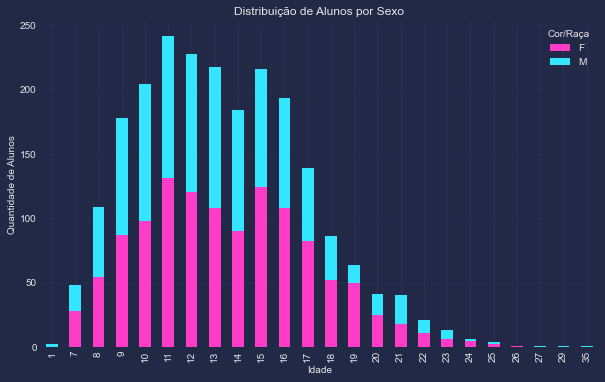

In [272]:
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'M': '#34E5FF',  
    'F': '#FF3CC7'
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo.groupby(['Idade', 'Sexo']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição de Alunos por Sexo')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

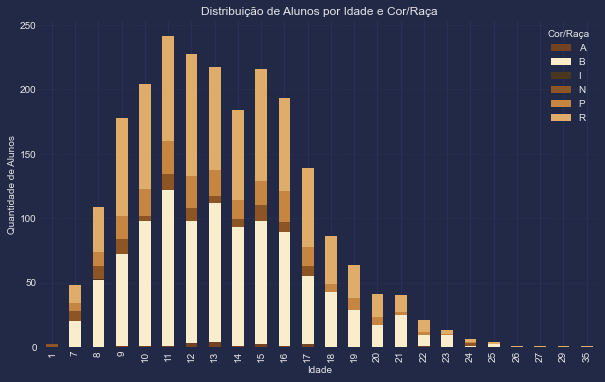

In [273]:
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'B': '#F9EDCC',  # Tom claro
    'R': '#E0AC69',  # Tom médio
    'P': '#C68642',  # Tom médio escuro
    'N': '#8D5524',  # Tom escuro
    'A': '#734222',  # Tom muito escuro
    'I': '#4B3621'   # Tom específico ou muito escuro
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo.groupby(['Idade', 'CorRaca']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição de Alunos por Idade e Cor/Raça')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

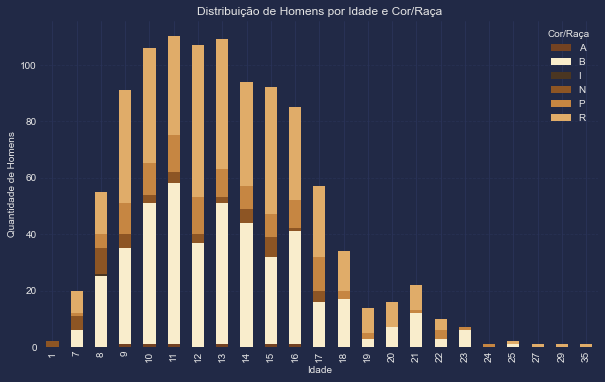

In [274]:
#### Grafico de raca de HOMENS APENAS
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'B': '#F9EDCC',  # Tom claro
    'R': '#E0AC69',  # Tom médio
    'P': '#C68642',  # Tom médio escuro
    'N': '#8D5524',  # Tom escuro
    'A': '#734222',  # Tom muito escuro
    'I': '#4B3621'   # Tom específico ou muito escuro
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo[tbAlunoResumo.Sexo == 'M'].groupby(['Idade', 'CorRaca']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Homens')
plt.title('Distribuição de Homens por Idade e Cor/Raça')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

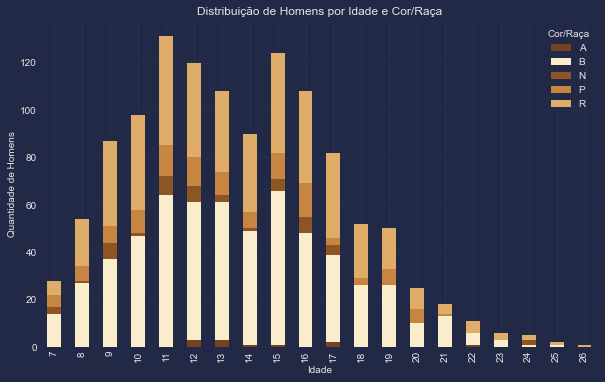

In [275]:
#### Grafico de raca de MULHERES APENAS
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'B': '#F9EDCC',  # Tom claro
    'R': '#E0AC69',  # Tom médio
    'P': '#C68642',  # Tom médio escuro
    'N': '#8D5524',  # Tom escuro
    'A': '#734222',  # Tom muito escuro
    'I': '#4B3621'   # Tom específico ou muito escuro
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo[tbAlunoResumo.Sexo == 'F'].groupby(['Idade', 'CorRaca']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Homens')
plt.title('Distribuição de Homens por Idade e Cor/Raça')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [276]:
tbAlunoResumo.StatusResponsavel.unique()

array(['Apenas mae cadastrada', 'Apenas pai cadastrado',
       'Nenhum cadastrado', 'Ambos Cadastros'], dtype=object)

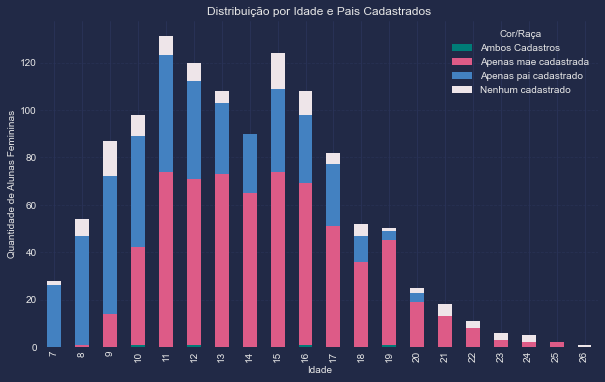

In [277]:
#### Grafico de raca de MULHERES APENAS
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'Apenas mae cadastrada': '#DD5B87', 
    'Apenas pai cadastrado': '#4381C1',  
    'Nenhum cadastrado': '#EEE5E9',  
    'Ambos Cadastros': '#007C77'
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo[tbAlunoResumo.Sexo == 'F'].groupby(['Idade', 'StatusResponsavel']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunas Femininas')
plt.title('Distribuição por Idade e Pais Cadastrados')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

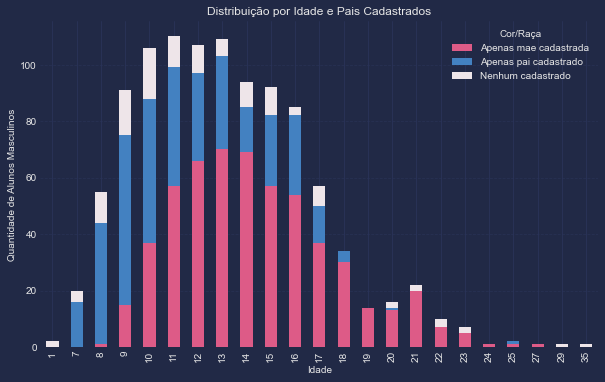

In [278]:
#### Grafico de raca de HOMENS APENAS
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'Apenas mae cadastrada': '#DD5B87', 
    'Apenas pai cadastrado': '#4381C1',  
    'Nenhum cadastrado': '#EEE5E9',  
    'Ambos Cadastros': '#007C77'
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo[tbAlunoResumo.Sexo == 'M'].groupby(['Idade', 'StatusResponsavel']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos Masculinos')
plt.title('Distribuição por Idade e Pais Cadastrados')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

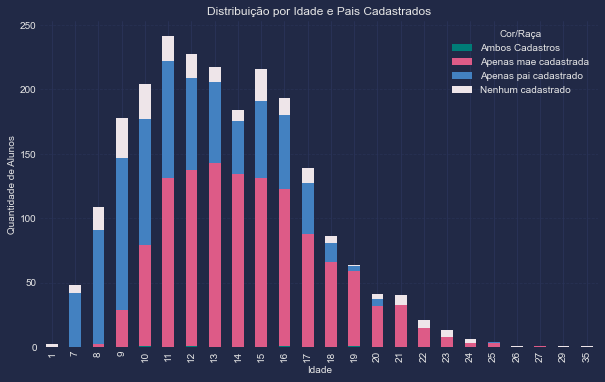

In [279]:
#### Grafico de raca de Total
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'Apenas mae cadastrada': '#DD5B87', 
    'Apenas pai cadastrado': '#4381C1',  
    'Nenhum cadastrado': '#EEE5E9',  
    'Ambos Cadastros': '#007C77'
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbAlunoResumo.groupby(['Idade', 'StatusResponsavel']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição por Idade e Pais Cadastrados')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [280]:
# Carregando tabela de historico
tbHistorico = pd.read_csv('database/tbHistorico.csv')
tbHistorico.shape

(134, 16)

In [281]:
# Printa das colunas que vamos analisar
tbHistorico.columns

Index(['IdAluno', 'CodigoSerie', 'AnoConclusao', 'ResultadoFinal',
       'IdEstabelecimentoEnsino', 'DiasLetivos', 'CargaHorariaTotal',
       'Observacao', 'IdSerie', 'CargaHorariaTotalExibicao', 'StCHIgnorarSoma',
       'FrequenciaTotal', 'CargaHorariaTotalHoraMinuto',
       'CargaHorariaTotalHoraMinutoExibicao',
       'StUsaCargaHorariaTotalHoraMinutoTexto', 'TotalFaltasTexto'],
      dtype='object')

In [282]:
# Contar o número de alunos únicos na base de dados
print(f'[tbHistorico] - Há {tbHistorico.IdAluno.nunique()} alunos distintos na base!!')

[tbHistorico] - Há 124 alunos distintos na base!!


In [283]:
# Cruzando informacoes dos alunos que temos com historico
tbCentral = pd.merge(
    tbAlunoResumo,
    tbHistorico[['IdAluno','AnoConclusao','ResultadoFinal']],
    how='left',
    on='IdAluno'
)

In [284]:
# Visualizando informacoes que encontramos historicos
tbCentral[~(tbCentral['AnoConclusao'].isnull())]

,IdAluno,Sexo,Idade,DataNascimento,CorRaca,StatusResponsavel,AnoConclusao,ResultadoFinal
0,3,F,19,2005-03-29 03:00:00,R,Apenas mae cadastrada,2021.0,A
1,4,F,19,2004-11-04 02:00:00,B,Apenas pai cadastrado,2021.0,A
5,8,F,22,2002-03-02 03:00:00,B,Apenas mae cadastrada,2021.0,A
9,12,F,19,2004-12-24 02:00:00,B,Apenas mae cadastrada,2021.0,A
12,15,F,19,2004-09-05 03:00:00,B,Apenas mae cadastrada,2021.0,A
...,...,...,...,...,...,...,...,...
2156,2173,M,17,2007-02-12 00:00:00,R,Apenas pai cadastrado,2024.0,C
2161,2178,F,17,2006-09-28 00:00:00,B,Apenas pai cadastrado,2024.0,C
2162,2179,F,17,2007-05-07 00:00:00,B,Apenas pai cadastrado,2024.0,C
2163,2180,F,17,2007-06-08 00:00:00,B,Apenas pai cadastrado,2024.0,C


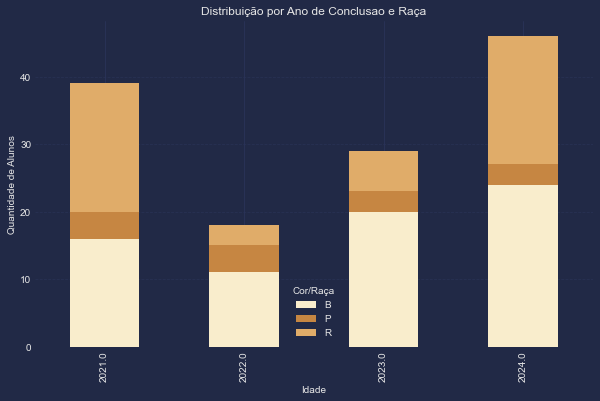

In [285]:
#### Grafico de conclusao por etinia
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'B': '#F9EDCC',  # Tom claro
    'R': '#E0AC69',  # Tom médio
    'P': '#C68642',  # Tom médio escuro
    'N': '#8D5524',  # Tom escuro
    'A': '#734222',  # Tom muito escuro
    'I': '#4B3621'   # Tom específico ou muito escuro
}
# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbCentral.groupby(['AnoConclusao', 'CorRaca']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição por Ano de Conclusao e Raça')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

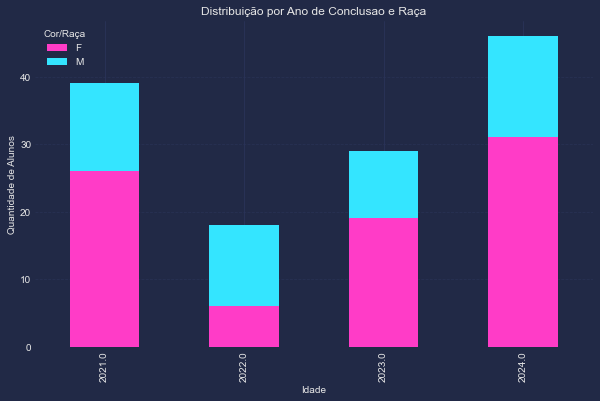

In [286]:
#### Grafico de conclusao por sexo
# Definindo cores personalizadas para cada categoria de Sexo
colors = {
    'M': '#34E5FF',  
    'F': '#FF3CC7'
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbCentral.groupby(['AnoConclusao', 'Sexo']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição por Ano de Conclusao e Raça')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

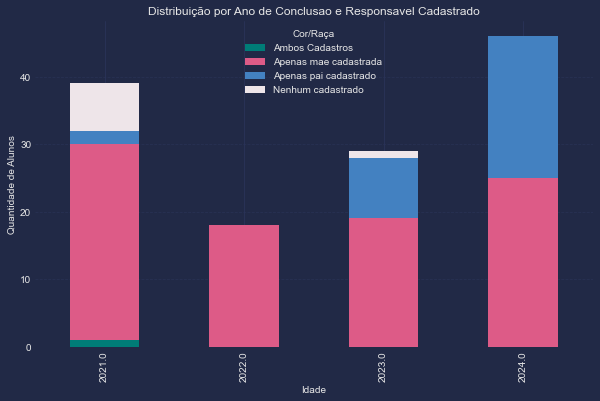

In [287]:
#### Grafico de conclusao por sexo
# Definindo cores personalizadas para cada categoria de Sexo
colors = {
    'Apenas mae cadastrada': '#DD5B87', 
    'Apenas pai cadastrado': '#4381C1',  
    'Nenhum cadastrado': '#EEE5E9',  
    'Ambos Cadastros': '#007C77'
}

# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbCentral.groupby(['AnoConclusao', 'StatusResponsavel']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição por Ano de Conclusao e Responsavel Cadastrado')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

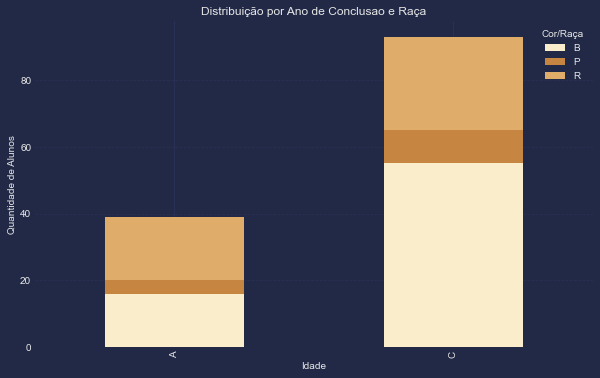

In [288]:
#### Grafico de conclusao por etinia
# Definindo cores personalizadas para cada categoria de CorRaca
colors = {
    'B': '#F9EDCC',  # Tom claro
    'R': '#E0AC69',  # Tom médio
    'P': '#C68642',  # Tom médio escuro
    'N': '#8D5524',  # Tom escuro
    'A': '#734222',  # Tom muito escuro
    'I': '#4B3621'   # Tom específico ou muito escuro
}
# Agrupando os dados por idade e cor/raca e contando a quantidade de alunos
df_grouped = tbCentral.groupby(['ResultadoFinal', 'CorRaca']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns], figsize=(10, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade de Alunos')
plt.title('Distribuição por Ano de Conclusao e Raça')
plt.legend(title='Cor/Raça')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [289]:
tbCentral.head()

,IdAluno,Sexo,Idade,DataNascimento,CorRaca,StatusResponsavel,AnoConclusao,ResultadoFinal
0,3,F,19,2005-03-29 03:00:00,R,Apenas mae cadastrada,2021.0,A
1,4,F,19,2004-11-04 02:00:00,B,Apenas pai cadastrado,2021.0,A
2,5,F,22,2002-01-25 02:00:00,B,Nenhum cadastrado,NaN,NaN
3,6,M,21,2002-10-07 03:00:00,R,Apenas mae cadastrada,NaN,NaN
4,7,M,21,2002-12-23 02:00:00,R,Apenas mae cadastrada,NaN,NaN


In [290]:
tbCentral.to_csv(r'bases_finais/alunos.csv', index=False)

In [291]:
# Carregar as novas tabelas para a análise de distribuição de notas dos alunos
df_fase_nota = pd.read_csv('database/TbFaseNota.csv')
df_fase_nota_aluno = pd.read_csv('database/TbFaseNotaAluno.csv')
df_fase_nota_origem_destino = pd.read_csv('database/TbFaseNotaOrigemDestino.csv')
df_fase_nota_disciplina_turma = pd.read_csv('database/TbFaseNotaDisciplinaTurma.csv')

# Combinando as tabelas TbFaseNotaAluno com TbFaseNotaDisciplinaTurma para obter as notas por disciplina e turma
df_notas_completa = pd.merge(df_fase_nota_aluno, df_fase_nota_disciplina_turma, on='IdFaseNota')

# Filtrando para obter apenas as notas finais e limpando os dados
notas_alunos = df_notas_completa['NotaFase'].dropna()

# Contagem de alunos únicos que possuem nota após a limpeza
alunos_com_nota = df_notas_completa[df_notas_completa['NotaFase'] > 0]['IdAluno'].nunique()

alunos_com_nota

325

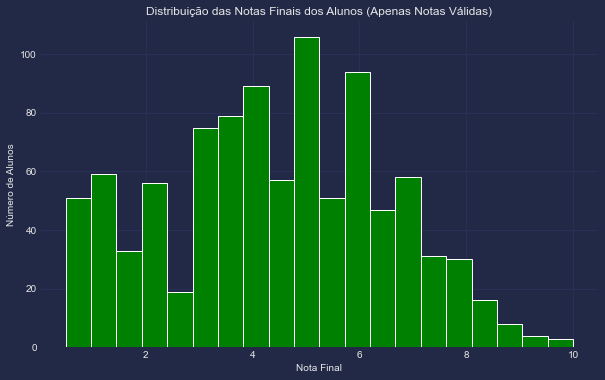

In [292]:
# Limpar as notas negativas e nulas (incluindo zero)
notas_limpa = notas_alunos[notas_alunos > 0]

# Plotando a distribuição das notas finais limpas
plt.figure(figsize=(10, 6))
plt.hist(notas_limpa, bins=20, color='green', edgecolor='white')
plt.title('Distribuição das Notas Finais dos Alunos (Apenas Notas Válidas)')
plt.xlabel('Nota Final')
plt.ylabel('Número de Alunos')
plt.grid(True)
plt.show()

In [293]:
## Analisando base FIAP
tb2020 = pd.read_csv(r'bases_finais/dados_2020.csv')
tb2021 = pd.read_csv(r'bases_finais/dados_2021.csv')
tb2022 = pd.read_csv(r'bases_finais/dados_2022.csv')

In [294]:
# Dando uma olhada no dataset 
tb2020.head(3)

,INSTITUICAO_ENSINO_ALUNO_2020,NOME,IDADE_ALUNO_2020,ANOS_PM_2020,FASE_TURMA_2020,PONTO_VIRADA_2020,INDE_2020,INDE_CONCEITO_2020,PEDRA_2020,DESTAQUE_IEG_2020,DESTAQUE_IDA_2020,DESTAQUE_IPV_2020,IAA_2020,IEG_2020,IPS_2020,IDA_2020,IPP_2020,IPV_2020,IAN_2020
0,Escola Pública,ALUNO-1,11,2,2H,Não,7.883.752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.500.020.000.000.000,8.7,7.5,7,59.375,7.75,10
1,Escola Pública,ALUNO-3,12,2,3H,Não,7.856.389.666.666.660,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,791.667,8.9,7.5,5.5,8.125,8.111.113.333.333.330,10
2,Escola Pública,ALUNO-4,10,2,1D,Não,5.076.252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.000.020.000.000.000,4.1,6.875,0,71.875,7.75,5


In [295]:
# Criando um campo de contagem
tb2020['qtd'] = 1

# Criando uma base resumo só com o que precisamos
tb2020_resumo = tb2020[['INSTITUICAO_ENSINO_ALUNO_2020','qtd','IDADE_ALUNO_2020','PONTO_VIRADA_2020','PEDRA_2020']].groupby(
    by=['INSTITUICAO_ENSINO_ALUNO_2020','IDADE_ALUNO_2020','PONTO_VIRADA_2020','PEDRA_2020']
).sum().reset_index()

# Visualizando tabela
tb2020_resumo.head()

,INSTITUICAO_ENSINO_ALUNO_2020,IDADE_ALUNO_2020,PONTO_VIRADA_2020,PEDRA_2020,qtd
0,Escola João Paulo II,12,Não,Ágata,1
1,Escola João Paulo II,13,Não,Quartzo,1
2,Escola Pública,10,Não,Ametista,49
3,Escola Pública,10,Não,Quartzo,15
4,Escola Pública,10,Não,Topázio,2


In [296]:
tb2020_resumo.PEDRA_2020.unique()

array(['Ágata', 'Quartzo', 'Ametista', 'Topázio', 'D9891/2A'],
      dtype=object)

In [297]:
# Retirando caso nao mapeado 
tb2020_resumo = tb2020_resumo[tb2020_resumo.PEDRA_2020 != 'D9891/2A']

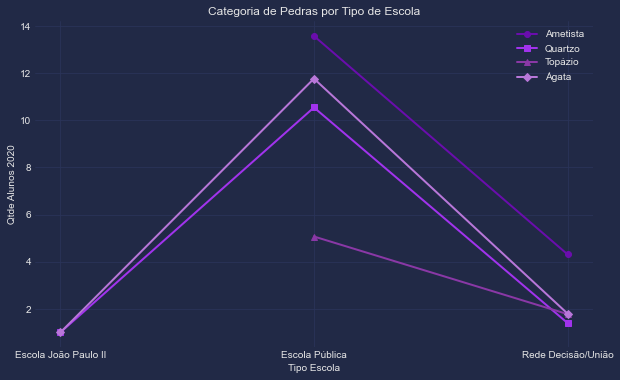

In [300]:
# Criar uma tabela dinâmica para lidar com duplicatas
df_pivot = tb2020_resumo.pivot_table(index='INSTITUICAO_ENSINO_ALUNO_2020', columns='PEDRA_2020', values='qtd')

# Cores de roxo diferentes
cores = ['#6A0DAD', '#A133ED', '#8A38A6', '#B877D9']

# Estilos de marcadores diferentes
marcadores = ['o', 's', '^', 'D']

# Criar o gráfico de linha
plt.figure(figsize=(10, 6))
for i, categoria in enumerate(df_pivot.columns):
    plt.plot(df_pivot.index, df_pivot[categoria], label=categoria, color=cores[i], marker=marcadores[i], linewidth=2) 

# Configurar o título e os rótulos dos eixos
plt.title('Categoria de Pedras por Tipo de Escola')
plt.xlabel('Tipo Escola')
plt.ylabel('Qtde Alunos 2020')
plt.legend()

# Exporta a imagem para ser usada no relatorio
plt.savefig('imagens/categ_alunos_tipo_escola_2020.png', dpi=300)

# Mostrar o gráfico
plt.show()